# Detecting Ingroup and Outgroup using Word Embeddings

In this experiment we experiment with Word Embeddings for detecting the ingroup and outgroup of a text.

Word embedding refers to the numeric representation of words as vectors in relation to each other in a sentence. Representing words as vectors is based on the distributional hypothesis, perhaps best stated as “You shall know a word by the company it keeps”. By representing words in a vector array a semantic distance between words is created by determining the number of words between key words. This word embedding technique is coded in to the Word2Vec algorithm and is available as open source from the Gensim library.

The experiment is structured by 3 tests:
Test 1 - Find Most Similar Words to Seed Terms 'Friend' and 'Terrorism'
Test 2 - Find Words Closely Associated With Named Entities of the Document.
Test 3 - Create a Word Plot of the Word Embeddings

## Loading the Dataset

In [15]:
%%time

import os
from datetime import datetime
import json

## George Bush Speeches

print('loading doc')

FileList = ['20010114-Remarks at the National Day of Prayer & Remembrance Service.txt',
            '20010115-First Radio Address following 911.txt',
            '20010117-Address at Islamic Center of Washington, D.C..txt',
           '20010120-Address to Joint Session of Congress Following 911 Attacks.txt',
           '20010911-Address to the Nation.txt',
           '20011007-Operation Enduring Freedom in Afghanistan Address to the Nation.txt',
           '20011011-911 Pentagon Remembrance Address.txt',
           '20011011-Prime Time News Conference on War on Terror.txt',
           '20011026-Address on Signing the USA Patriot Act of 2001.txt',
           '20011110-First Address to the United Nations General Assembly.txt',
           '20011211-Address to Citadel Cadets.txt',
           '20011211-The World Will Always Remember 911.txt',
           '20020129-First (Official) Presidential State of the Union Address.txt',
           ]
raw = ''



filepath = "C:/Users/Steve/OneDrive - University of Southampton/CulturalViolence/KnowledgeBases/Speeches/George Bush/"

for f in FileList:
    with open(os.path.join(filepath, f), 'r') as text:
        raw = raw + text.read()

print('doc length', len(raw))
print('complete at: ', datetime.now().strftime("%d/%m/%Y - %H:%M:%S"))


loading doc
doc length 111934
complete at:  24/02/2020 - 15:36:08
Wall time: 82.8 ms


## Setting up the spaCy pipeline

In [6]:
%%time

# Setup  pipline

print('loading libraries')
import spacy

from spacy.pipeline import merge_entities
from spacy.pipeline import merge_noun_chunks

print('setting up pipeline')
#coref_nlp = spacy.load('en_coref_md')
spacy_nlp = spacy.load('en_core_web_md')
#spacy_nlp.add_pipe(merge_noun_chunks, after = 'ner')
spacy_nlp.add_pipe(merge_entities, after = 'ner')

#coref_doc = coref_nlp(doc)
doc = spacy_nlp(raw) #replace co-reference entities with root reference


print('complete at: ', datetime.now().strftime("%d/%m/%Y - %H:%M:%S"))

loading libraries
setting up pipeline
complete at:  24/02/2020 - 15:32:53
Wall time: 24.9 s


## Test 1 - Reviewing the Dataset

The 'window' from the Word2Vec method refers to the number of words either side of a seed word should be considered in the semantic relationship.

- model = word2vec.Word2Vec(doc_array, size=500, window=5, min_count=1, workers=4, sg=1)

Shown here are the words either side of interesting seed words and named entities from within Bush's speeches to show how incorrect similarities can be inferred. 

As can be seen, terms such as 'enemy' can be used in noun phrases such as 'enemy of America'. The word2vec methodology, therefore, would infer a relationship between these terms. In the example below, there are seven mismatched terms. 

This means there is a requirement to tune the dataset so that noun phrases, such as 'enemy of America' can be correctly annotated as 'ingroup' or 'outgroup'.

In [7]:
%%time

##setup interesting seed words

ingroup_concepts = ['friend']
outgroup_concepts = ['enemy', 'terrorist']
ingroup_entities = ['america', 'great britain', 'afghanistan', 'the united states of america', 'islam']
outgroup_entities = ['al qaeda', 'taliban']
group_types = ['ORG', 'NORP', 'PERSON', 'GPE']

correction = 0

for token in doc:
    window = []
    closest_entity = ''
    
    if token.lower_ in ingroup_concepts + outgroup_concepts:
        for n in range(-5, 6):
            if str(doc[token.i + n]) == '\n':
                pass
            else:
                window.append(doc[token.i + n])
                
        
        
        for entity in window:
            if entity.ent_type_ in group_types:
                
                for n in range(1, 6):
                    
                    if doc[token.i + n].ent_type_ in group_types:
                        closest_entity = doc[token.i + n]
                        break
                    
                    if doc[token.i - n].ent_type_ in group_types:
                        closest_entity = doc[token.i - n]
                        break

                print(' | '.join(map(str, window)))
                
                print('closest terms = ', token, ':', closest_entity)
                
                if token.lower_ in outgroup_concepts and str(closest_entity).lower() in ingroup_entities:
                    print('incorrect match')
                    correction += 1
                    
                if token.lower_ in ingroup_concepts and str(closest_entity).lower() in outgroup_entities:
                    print('incorrect match')
                    correction += 1
                    
                print()
                print('-----')
                print()
                break

print('number of incorrect matches: ', correction)
print('complete at: ', datetime.now().strftime("%d/%m/%Y - %H:%M:%S"))

. | America | has | no | truer | friend | than | Great Britain | . | Once | again
closest terms =  friend : Great Britain

-----

a | collection | of | loosely | affiliated | terrorist | organizations | known | as | al Qaeda | .
closest terms =  terrorist : al Qaeda

-----

Close | immediately | and | permanently | every | terrorist | training | camp | in | Afghanistan | ,
closest terms =  terrorist : Afghanistan
incorrect match

-----

Give | the United States | full | access | to | terrorist | training | camps | , | so | we
closest terms =  terrorist : the United States

-----

hijack | Islam | itself | . | The | enemy | of | America | is | not | our
closest terms =  enemy : America
incorrect match

-----

many | Arab | friends | . | Our | enemy | is | a | radical | network | of
closest terms =  enemy : Arab

-----

true | patriot | , | a | trusted | friend | -- | Pennsylvania | 's | Tom Ridge | .
closest terms =  friend : Pennsylvania

-----

has | begun | strikes | against | Al Qae

In [86]:
### the purpose of this cell is to tokenize 'enemies of america'

i = 0

should_restart = True

while should_restart:
    
    should_restart = False
    
    for i in range(len(new_doc)):
        #print(str(new_doc[i].lower_).find('enemy'))
        if str(new_doc[i].lower_).find('enem') >= 0 and str(new_doc[i+1].lower_) == 'of': # and new_doc[i+2].lower_ == 'america':
            print("{} {} {}".format(new_doc[i], new_doc[i+1], new_doc[i+2]))
            with new_doc.retokenize() as retokenizer:
                retokenizer.merge(new_doc[i:i+3])
            should_restart = True
            break

print('complete')

the enemy of the Ummah
the enemy of idolising
an enemy of God
complete


## Clean the document, create the doc_array and word2vec model

In [11]:
%%time

entity_array = []
doc_array = []
entity_set = set()
outgroup_ids = {'-outgroup-', 'enemies', 'enemy', 'terrorists', 'terrorist', 'regime', 'murderer', 'murderers', 'infidels', 'aposates', 'outlaws', 'crusaders', 'kuffaar', 'kuffar', 'kufr' 'invaders'}
ingroup_ids = {'-ingroup-', 'we', 'us', 'our', 'ours', 'ourselves', 'friend', 'friends', 'sons', 'daughters', 'brethren', 'ummah', 'brothers', 'sisters', 'martyr', 'martyrs'}
outgroup_nouns = set()
ingroup_nouns = set()
ents_set = set()

## extract named entities from the doc object
for entity in doc.ents:
    if entity.label_ in {'ORG', 'PERSON', 'GPE'}:
        ents_set.add(entity.lower_)
      

## 
## extract proper nouns and noun phrases from doc object
## proper nouns : entity_set
## ingroup noun phrases : ingroup_nouns
## outgroup noun phrases : outgroup_nouns

    
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

print('Tokenizing document')

#'PERSON', 'ORG', 'NORP', 'GPE'
entity_test = 'ORG'

for sentence in doc.sents:
    for token in sentence:
        
        if token in entity_set:
            print(token)
            
        token_lemma = lemmatizer.lemmatize(token.text.strip().lower(), pos="v")
                
        if token_lemma not in spacy_stopwords and not token.is_punct and token.text.find('\n') and not token.is_space and token.pos_ != 'PARTICLE':
            doc_array.append([token_lemma])
        
        if token.pos_ in ['PROPN']: # create a set of document proper nouns
            entity_set.add(token_lemma)
            
        w = set(token_lemma.split())
        
        if token.tag_ in {'NN', 'NNP', 'NNPS', 'NNS'} and not outgroup_ids.isdisjoint(w): # create a set of outgroup noun spans
            outgroup_nouns.add(token.lower_)
            
        elif token.tag_ in {'NN', 'NNP', 'NNPS', 'NNS'} and not ingroup_ids.isdisjoint(w): # create a set of ingroup noun spans
            ingroup_nouns.add(token.lower_)

print('complete')
print('entity_set: ', len(entity_set))
print('outgroup_nouns: ', len(outgroup_nouns))
print('ingroups_nouns: ', len(ingroup_nouns))

print('Creating Word2Vec model')
from gensim.models import word2vec
model = word2vec.Word2Vec(doc_array, size=500, window=5, min_count=1, workers=4, sg=1)
print('complete at: ', datetime.now().strftime("%d/%m/%Y - %H:%M:%S"))

Tokenizing document
complete
entity_set:  293
outgroup_nouns:  7
ingroups_nouns:  7
Creating Word2Vec model
complete at:  24/02/2020 - 15:33:43
Wall time: 677 ms


## Display Identified Noun Phrases in the Document

In [25]:
filepath = "C:/Users/Steve/OneDrive - University of Southampton/CulturalViolence/KnowledgeBases/Data/"

with open(os.path.join(filepath, "groups_benchmark.json"), 'r') as fp:
            groups_benchmark = json.load(fp)

# orator, group, term, ms1, ms2, ms3

for k, v in groups_benchmark.items():
    for key, value in v.items():
        print(k, '=>', key)
        for term in value:
            try:
                print(model.wv.most_similar(value))
            except:
                pass

bush => ingroup
bush => outgroup
binladen => ingroup
binladen => outgroup


## Test 2 - Find Most Similar Words to Identitified Entities from the Text

Do the similar words provide any meaning to the seed terms?

In [14]:
%%time

import pandas as pd

try:
    print('words most similar to \'friend\'')
    display(pd.DataFrame(model.wv.most_similar('friend'), columns = ['WORD', 'SIMILARITY']).round(decimals = 3))
except:
    pass
print('-----')
try:
    print('words most similar to \'terrorist\'')
    display(pd.DataFrame(model.wv.most_similar('terrorist'), columns = ['WORD', 'SIMILARITY']).round(decimals = 3))
except:
    pass

words most similar to 'friend'


,WORD,SIMILARITY
0,heirs,0.149
1,strength,0.147
2,four short months,0.140
3,mere,0.135
4,neutral,0.132
5,uphold,0.128
6,child,0.126
7,feel,0.123
8,focus,0.121
9,great britain,0.120


-----
words most similar to 'terrorist'


,WORD,SIMILARITY
0,huddle,0.158
1,agile,0.145
2,radical,0.133
3,proud,0.131
4,end,0.130
5,request,0.128
6,trial,0.128
7,overseas,0.128
8,multiply,0.126
9,atrocity,0.126


Wall time: 105 ms


## Test 3 - Find Words Closely Associated With Named Entities of the Document.

Do the associated terms provide any meaning?

In [39]:
%%time

for entity in ents_set:
    n = 50
    try:
        entity_similarity_list = model.wv.most_similar(str(entity))
        print(str(entity).ljust(n))
        
        for element in entity_similarity_list[0:11]:
            for i in element:
                if isinstance(i, float):
                    print(round(i, 3), end=' | ')
                else:
                    print(str(i), end=': ')
        print()
        print('-----')
        
    except:
        print(entity, ' : word not in Vocab')
        print('-----')

lott                                              
power: 0.152 | our grief: 0.142 | the global terror network: 0.136 | influence: 0.136 | the last nine days: 0.128 | dramatically: 0.126 | police forces: 0.117 | resolute: 0.113 | the news: 0.106 | a dark threat: 0.101 | 
-----
america's resolve                                 
all the murderous ideologies: 0.136 | destroy: 0.124 | many questions: 0.122 | air marshals: 0.118 | right: 0.113 | its own people: 0.112 | close: 0.112 | our airlines: 0.11 | police forces: 0.104 | friends: 0.104 | 
-----
australia                                         
the needs: 0.133 | fbi agents: 0.131 | dangers: 0.129 | no such report: 0.127 | a voice: 0.12 | two years ago: 0.12 | remake: 0.109 | dictate: 0.101 | past: 0.101 | new york: 0.1 | 
-----
virginia                                          
our command: 0.157 | falter: 0.123 | our prayers: 0.113 | our principles: 0.111 | no ground troops: 0.109 | alert: 0.109 | their own citizens: 0.1 | hebrew: 0

## Test 4 - Create a Word Plot of the Word Embeddings

Are there any meaningful clusters in the graphic?

creating tokens and labels


C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


building tsne model


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:326: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


constructing graph


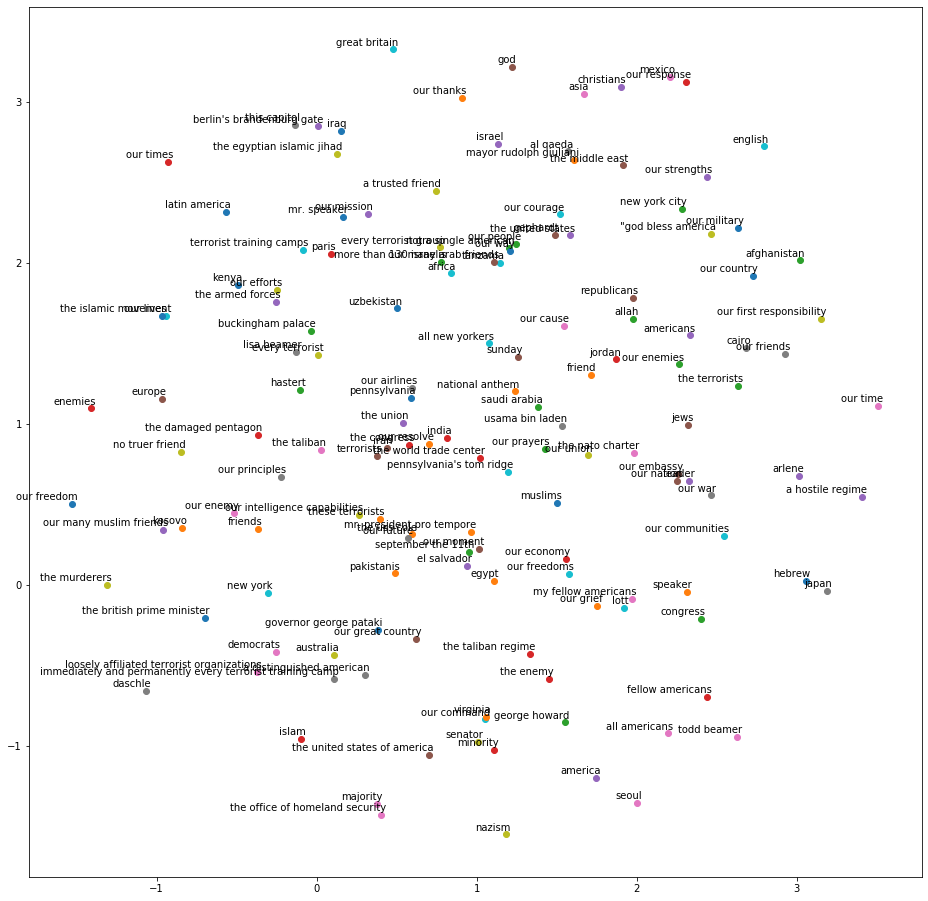

Wall time: 2.21 s


In [40]:
%%time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print('creating tokens and labels')
    for word in model.wv.vocab:
        if word in entity_set | ingroup_nouns | outgroup_nouns:
            tokens.append(model[word])
            labels.append(word)
    
    print('building tsne model')
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    print('constructing graph')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
        plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
    plt.show()
    
tsne_plot(model)

In [ ]:
ents_set = set()

#['PERSON', 'ORG', 'NORP', 'GPE']

entity_test = 'ORG'

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

if input('Extract from merged entities (y/n)? ').lower() == 'y':
    
    for ent in new_doc.ents: # use when merged entities
        if ent.label_ == entity_test:
            ents_set.add(lemmatizer.lemmatize(ent.text.strip().lower(), pos="v"))
            
else:
        
    for ent in new_doc: # use when un-merged entities
        if ent.ent_type_ == entity_test:
            ents_set.add(lemmatizer.lemmatize(ent.text.strip().lower(), pos="v"))
            
entity_set.append([lemmatizer.lemmatize(token.text.strip().lower(), pos="v") for token in sentence if 
                                            token.ent_type_ == entity_test])

            
print('Length ents_set: ', len(ents_set))